# The BioPlex protein-protein interactions data set

The present coding document is an analysis of the dataset of proteins interaction. It is relevant to the investigation of pathological processes at the cellular level. The main goal here is to complete missing informations from data with incomplete labels. 

This data is composed of labeled data and unlabeled data. The only known labeled data are proteins that are know to have a positive interation. That does mean the unlabeled may have an interraction, but are not yet labeled in an experiment. One thing we know for sure, is there are proteins that doesn't interact between each other. That means all the unlabeled data can't all be speculated as positive interraction. There has to have proteins that doesn't have interraction.

The main objective here is to pull information about unlabeled proteins that could potentionally have interactions together. 

The analysis of the data will be to take a training set, train a model with it, then test it on the rest of the data set. The number of dataset for the complete set is 6 millions, but for the purpose of the present study, we will use only a sampling of 370 thousands. Each data has 9 different parameters mesured and the class they belong to (labeled or unlabeled).

The method of machine learning choosen for the : 

* Polynomial basis function and linear classifier
* Multi Layer Perceptron
* Support Vector Machines with a radial basis funtion kernel
* Support Vector Machines with a sigmoidal kernel
* Model Ensembles with SVMs
* Model Ensembles with ANNs

The comparison will rest on the following test:
* Accuracy
* Recall
* F score

Futher explanations of the analysis will be giveng along the way


## Import packages

In [39]:
''' Python packages '''
import numpy as np
from matplotlib import pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

''' Project specific tools '''
from data_management import *
from models import *
from display import *
from metrics import *

''' Display configs '''
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset description
Load data, which contain 370k points (X) with 9 parameters each. The data are not normalized.

In [40]:
data_man = DataManager('BioPlex_PU_data.pkl')
P, U, _, _ = data_man.parse_pickle()

## Set for analysis
The following set of graphs show the normalized repartition of the nine (9) parameters from the data. Since WD and n_unique_peps have a very poor discriminatory information, it is fair to remove them from the list. 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


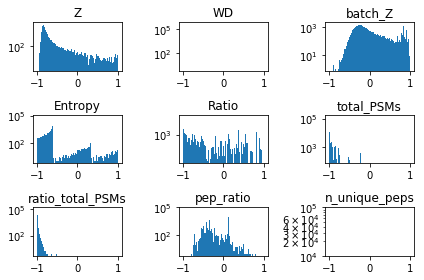

In [41]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, normalize=True)
X_norm = np.concatenate((x_train, x_test))
fig = FigureDrawer('Feature distributions')
fig.draw_hist_array(X_norm.T, labels=data_man.feature_labels)

In [42]:
x_train, t_train, _, _ = data_man.split_training_test(P, U, test_size=44000, PU_ratio=8., normalize=True, show_counts=True)
tsne = TSNE(n_jobs=6, perplexity=40, learning_rate=20, early_exaggeration=12, n_iter=5000) # n_iter=2000

len P_train: 1691
len P_test: 44000
len U_train: 13528
len U_test: 312005
 nP/nU: 0.125
len x_train: 15219
len x_test: 356005
nTest/total 0.959003189448958


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [43]:
x_8d = np.delete(x_train, [1,], axis=1)
x_7d = np.delete(x_train, [1,8], axis=1)

X_9d_embedded = tsne.fit_transform(x_train)[::-1]
X_8d_embedded = tsne.fit_transform(x_8d)[::-1]
X_7d_embedded = tsne.fit_transform(x_7d)[::-1]

In [44]:
x_tsne = (
    np.concatenate((X_9d_embedded, t_train[:,np.newaxis][::-1]), axis=1),
    np.concatenate((X_8d_embedded, t_train[:,np.newaxis][::-1]), axis=1), 
    np.concatenate((X_7d_embedded, t_train[:,np.newaxis][::-1]), axis=1), 
)

In [45]:
# remove
import pickle
pickle.dump(x_tsne, open('tsne.pkl', 'wb'))
x_tsne = pickle.load(open('tsne.pkl', 'rb'))

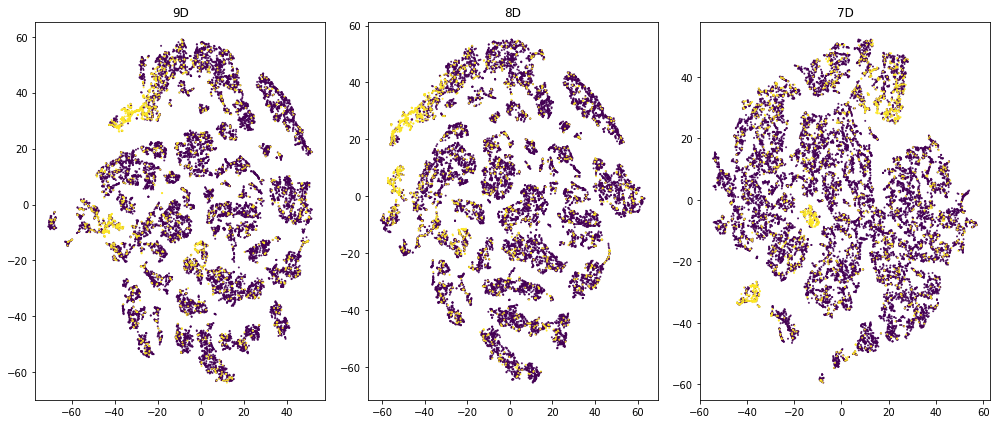

In [46]:
fig = FigureDrawer('T-SNE visualisation')
fig.draw_scatter_plot(x_tsne, labels=['9D', '8D', '7D'], figsize=(14,6))

# Polynomial basis function and linear classifier

In [47]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=0.8, normalize=True)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [48]:
lm = Model('linear', C=1, M=6, max_iter=5000)

In [49]:
lm.hyperpar_tuning(x_train, t_train)

{'C': 2, 'M': 3}

In [50]:
lm.train(x_train, t_train)

LinearSVC(C=2, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [51]:
t_pred = lm.predict(x_test)

In [52]:
metrics = Metrics()

In [53]:
metrics.accuracy(t_pred, t_test)

0.7200146620903173

In [54]:
metrics.recall(t_pred, t_test)

0.5887682745338353

In [55]:
metrics.LL_score(t_pred, t_test)

1.1860444808721438

## Multi Layer Perceptron

In [56]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=5., normalize=True)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [57]:
mlp = Model('MLP', neuron_per_layer=(50, 40, 30, 20, 10), max_iter=2000)

In [58]:
mlp.train(x_train, t_train)
t_pred = mlp.predict(x_test)

In [59]:
metrics = Metrics()

In [60]:
metrics.accuracy(t_pred, t_test)

0.9124849458048976

In [61]:
metrics.recall(t_pred, t_test)

0.2851264991683446

In [62]:
metrics.LL_score(t_pred, t_test)

1.7834032190474403

## Support Vector Machines 

In [63]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.95, normalize=True)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Radial Basis Funtion Kernel

In [64]:
svm_rbf = Model('SVM', kernel='rbf')

In [65]:
svm_rbf.train(x_train, t_train)
t_pred = svm_rbf.predict(x_test)

TypeError: must be real number, not str

In [ ]:
metrics.accuracy(t_pred, t_test)

In [ ]:
metrics.recall(t_pred, t_test)

### Sigmoidal Kernel

In [ ]:
svm_sig = Model('SVM', kernel='sigmoid')

In [ ]:
svm_sig.train(x_train, t_train)
t_pred = mlp.predict(x_test)

In [ ]:
metrics.recall(t_pred, t_test)

In [ ]:
metrics.LL_score(t_pred, t_test)

In [ ]:
metrics.accuracy(t_pred, t_test)

## Model Ensembles

### SVM ensemble

### ANN ensemble